In [3]:
#!/usr/bin/env pythonP
# coding: utf-8

import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma
from itertools import combinations

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from pylab import imshow,cm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  

#Import packages for clustering
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod


#Import packages for interpolating and filtering data
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed


In [4]:

parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
sys.path.append(parent_directory+"/subfunctions/latlon_transform") 
from parallelised_functions import split3D

sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
from Interpolant import generate_land_ocean_interpolant, parallel_interpolant_unsteady_land_ocean_mask
from velocity import land_mask_t




In [5]:
IC_resolution = 0.5
dt = 0.0025
DT = 0.1
freq = 1
e = 0
n_clusters = 20
# Format the variables
formatted_e = f"{e:.2f}"
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"
# Define other necessary variables
year = 2009
season = "AMJ"
# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
results_directory = file_path
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"
geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}.nc"
K=1000
distance = 4
k_exp = 100


if not os.path.exists(results_directory):
    os.makedirs(results_directory)

print("Reading data")
#Read input data
Fmap_path = file_path+'/Fmap_matrix.npy'
time_path = file_path+'/advection_time.npy'
W_path = file_path+'/W_matrix.npy'

# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
#Fmap=Fmap[:,:,::100]
# Load the time_adv_mod array from the file
time_adv_mod = np.load(time_path)
# Load the similarity matrix
W_vec = np.load(W_path)

dataset = nc.Dataset(regrided_geo_file_path, mode='r')
#from m/s to m/day
siu = dataset.variables['vlon'][:,:,:]
siu = np.transpose(siu, axes=(1, 2, 0))
land_mask_reg = dataset.variables['land_mask'][:,:]
# Access coordinates
lat_grid = dataset.variables['regrided_rot_lat'][:]  
lon_grid = dataset.variables['regrided_rot_lon'][:]
# Access specific variables
time_data = dataset.variables['time'][:] 
dataset.close()


Reading data


In [6]:
land_ocean_mask = np.copy(siu)
land_ocean_mask[land_ocean_mask != 0] = 1
Interpolant_land_mask = generate_land_ocean_interpolant(land_ocean_mask,lon_grid,lat_grid,10)

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True
l=[]
for i in range(time_adv_mod.shape[0]):
    l.append(land_mask_t(time_adv_mod[i], Fmap[i], lon_grid, lat_grid, Interpolant_land_mask, periodic, bool_unsteady, time_data, linear = False))

kill_trajectories = np.where(np.sum(l,axis=0)!=len(l))[0] #The trajectories that not have true (1) all the time don't reach the number of timesteps and therefore have to be removed


Generate interpolators for the advection
Time taken for parallel computation to generate the velocity interpolator objects: 4.10 seconds


In [8]:
Fmap[0,:,0]

array([-72.40638733, -37.97213745])

In [9]:
Fmap.shape

(908, 2, 3851)

In [8]:
n=Fmap.shape[2]
Fmap_cleaned = np.delete(Fmap,kill_trajectories,axis=2)
n_cleaned=Fmap_cleaned.shape[2]

In [11]:
def cleaner(n,n_cleaned,kill_trajectories,W_vec):
    indices = np.tril_indices(n,0,n)
    # Create an empty matrix of zeros with shape (n, n)
    W = np.zeros((n, n))
    W[indices] = W_vec
    # Fill the upper triangular part 
    W = W + W.T - np.diag(np.diag(W))
    W_cleaned = np.delete(W,kill_trajectories,axis=0)
    W_cleaned = np.delete(W_cleaned,kill_trajectories,axis=1)
    indices_cleaned = np.tril_indices(n_cleaned,0,n_cleaned)
    W_vec_cleaned = W_cleaned[indices_cleaned]
    return W_vec_cleaned

In [12]:
W_vec_cleaned = cleaner(n,n_cleaned,kill_trajectories,W_vec)

Text(0, 0.5, 'Number of trajectories that die')

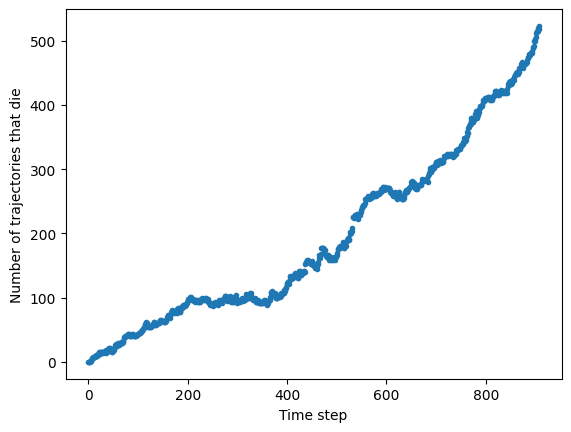

In [7]:
plt.plot(l[0].shape[0]-np.sum(l,axis=1),".")
plt.xlabel("Time step")
plt.ylabel("Number of trajectories that die")